In [8]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import SwinForImageClassification, AutoFeatureExtractor, Trainer, TrainingArguments
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random
import math
from PIL import Image
from transformers.data.data_collator import default_data_collator

# In ra phiên bản của các thư viện
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("transformers version:", transformers.__version__)
print("sklearn version:", sklearn.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)  # Sử dụng matplotlib.__version__ thay vì plt.__version__
print("seaborn version:", sns.__version__)
print("PIL version:", Image.__version__)


torch version: 2.4.1+cu121
torchvision version: 0.19.1+cu121
transformers version: 4.45.1
sklearn version: 1.5.1
numpy version: 1.26.4
matplotlib version: 3.9.2
seaborn version: 0.13.2
PIL version: 10.4.0


In [9]:
import transformers
print(transformers.__version__)

4.45.1


In [10]:
# Đường dẫn đến dữ liệu đã mount từ Windows sang Ubuntu
train_dir = "/mnt/d/Vit/Data/train"
valid_dir = "/mnt/d/Vit/Data/valid"
test_dir = "/mnt/d/Vit/Data/test"

In [11]:
# Sử dụng AutoFeatureExtractor để tiền xử lý dữ liệu đầu vào phù hợp với mô hình Swin Transformer
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-base-patch4-window7-224")

In [12]:
# Các phép biến đổi cho dữ liệu train và test
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

In [13]:
# Load dữ liệu train, valid, và test
train_dataset = ImageFolder(train_dir, transform=transform)
valid_dataset = ImageFolder(valid_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

In [14]:
# Lấy số lượng labels
num_labels = len(train_dataset.classes)

In [15]:
print(f"Số lượng nhãn: {num_labels}")
print(f"Tên của các nhãn: {train_dataset.classes}")

Số lượng nhãn: 5
Tên của các nhãn: ['Cam', 'Chidan', 'Hieulenh', 'Nguyhiem', 'Phu']


Một vài mẫu của tập train:


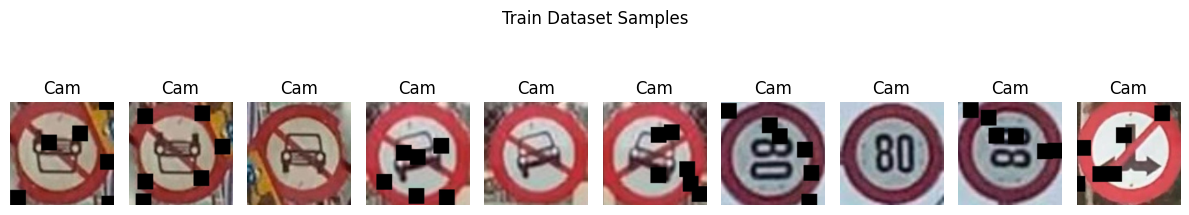

Một vài mẫu của tập valid:


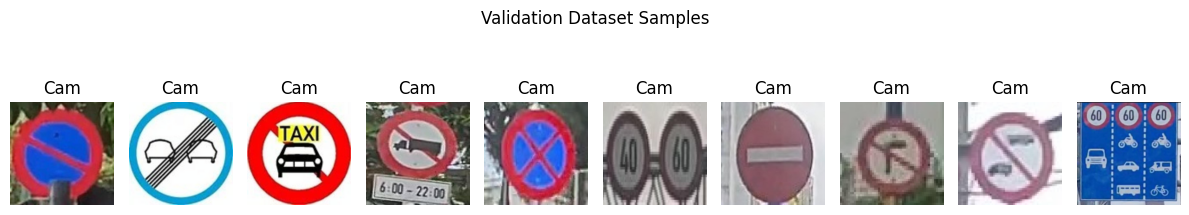

Một vài mẫu của tập test:


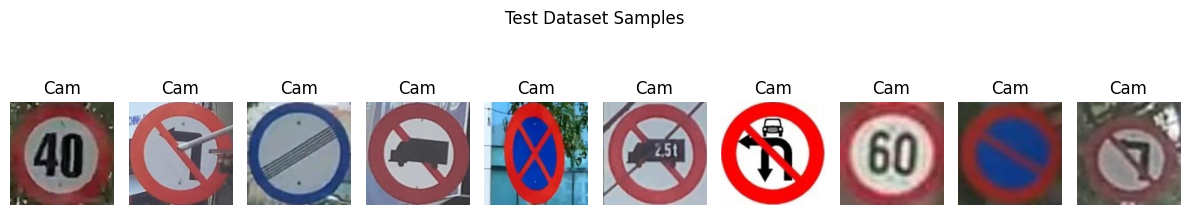

In [16]:
# Hàm để hiển thị một vài hình ảnh
def show_samples(dataset, title, num_samples=10):
    plt.figure(figsize=(12, 3))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Chuyển đổi tensor sang định dạng numpy và chuyển kênh ảnh từ (C, H, W) sang (H, W, C)
        img = np.clip(img * feature_extractor.image_std + feature_extractor.image_mean, 0, 1)  # Hoàn tác normalize để hiển thị ảnh đúng màu
        plt.imshow(img)
        plt.title(dataset.classes[label])
        plt.axis("off")
    plt.subplots_adjust(wspace=0.05, hspace=0.05, top=0.85)
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

# Hiển thị một vài hình ảnh từ tập train, valid và test
print("Một vài mẫu của tập train:")
show_samples(train_dataset, "Train Dataset Samples")

print("Một vài mẫu của tập valid:")
show_samples(valid_dataset, "Validation Dataset Samples")

print("Một vài mẫu của tập test:")
show_samples(test_dataset, "Test Dataset Samples")


In [17]:
# Lặp qua dataset và in ra label
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    print(f"Image {i}: Label = {label}, Class = {train_dataset.classes[label]}")

Image 0: Label = 0, Class = Cam
Image 1: Label = 0, Class = Cam
Image 2: Label = 0, Class = Cam
Image 3: Label = 0, Class = Cam
Image 4: Label = 0, Class = Cam
Image 5: Label = 0, Class = Cam
Image 6: Label = 0, Class = Cam
Image 7: Label = 0, Class = Cam
Image 8: Label = 0, Class = Cam
Image 9: Label = 0, Class = Cam
Image 10: Label = 0, Class = Cam
Image 11: Label = 0, Class = Cam
Image 12: Label = 0, Class = Cam
Image 13: Label = 0, Class = Cam
Image 14: Label = 0, Class = Cam
Image 15: Label = 0, Class = Cam
Image 16: Label = 0, Class = Cam
Image 17: Label = 0, Class = Cam
Image 18: Label = 0, Class = Cam
Image 19: Label = 0, Class = Cam
Image 20: Label = 0, Class = Cam
Image 21: Label = 0, Class = Cam
Image 22: Label = 0, Class = Cam
Image 23: Label = 0, Class = Cam
Image 24: Label = 0, Class = Cam
Image 25: Label = 0, Class = Cam
Image 26: Label = 0, Class = Cam
Image 27: Label = 0, Class = Cam
Image 28: Label = 0, Class = Cam
Image 29: Label = 0, Class = Cam
Image 30: Label = 0,

In [18]:
label_dirs = []
#Lặp qua các thư mục con (label) và lưu đường dẫn vào list
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        label_dirs.append(label_dir)

# In ra danh sách các đường dẫn
print(label_dirs)

['/mnt/d/Vit/Data/train/Cam', '/mnt/d/Vit/Data/train/Chidan', '/mnt/d/Vit/Data/train/Hieulenh', '/mnt/d/Vit/Data/train/Nguyhiem', '/mnt/d/Vit/Data/train/Phu']


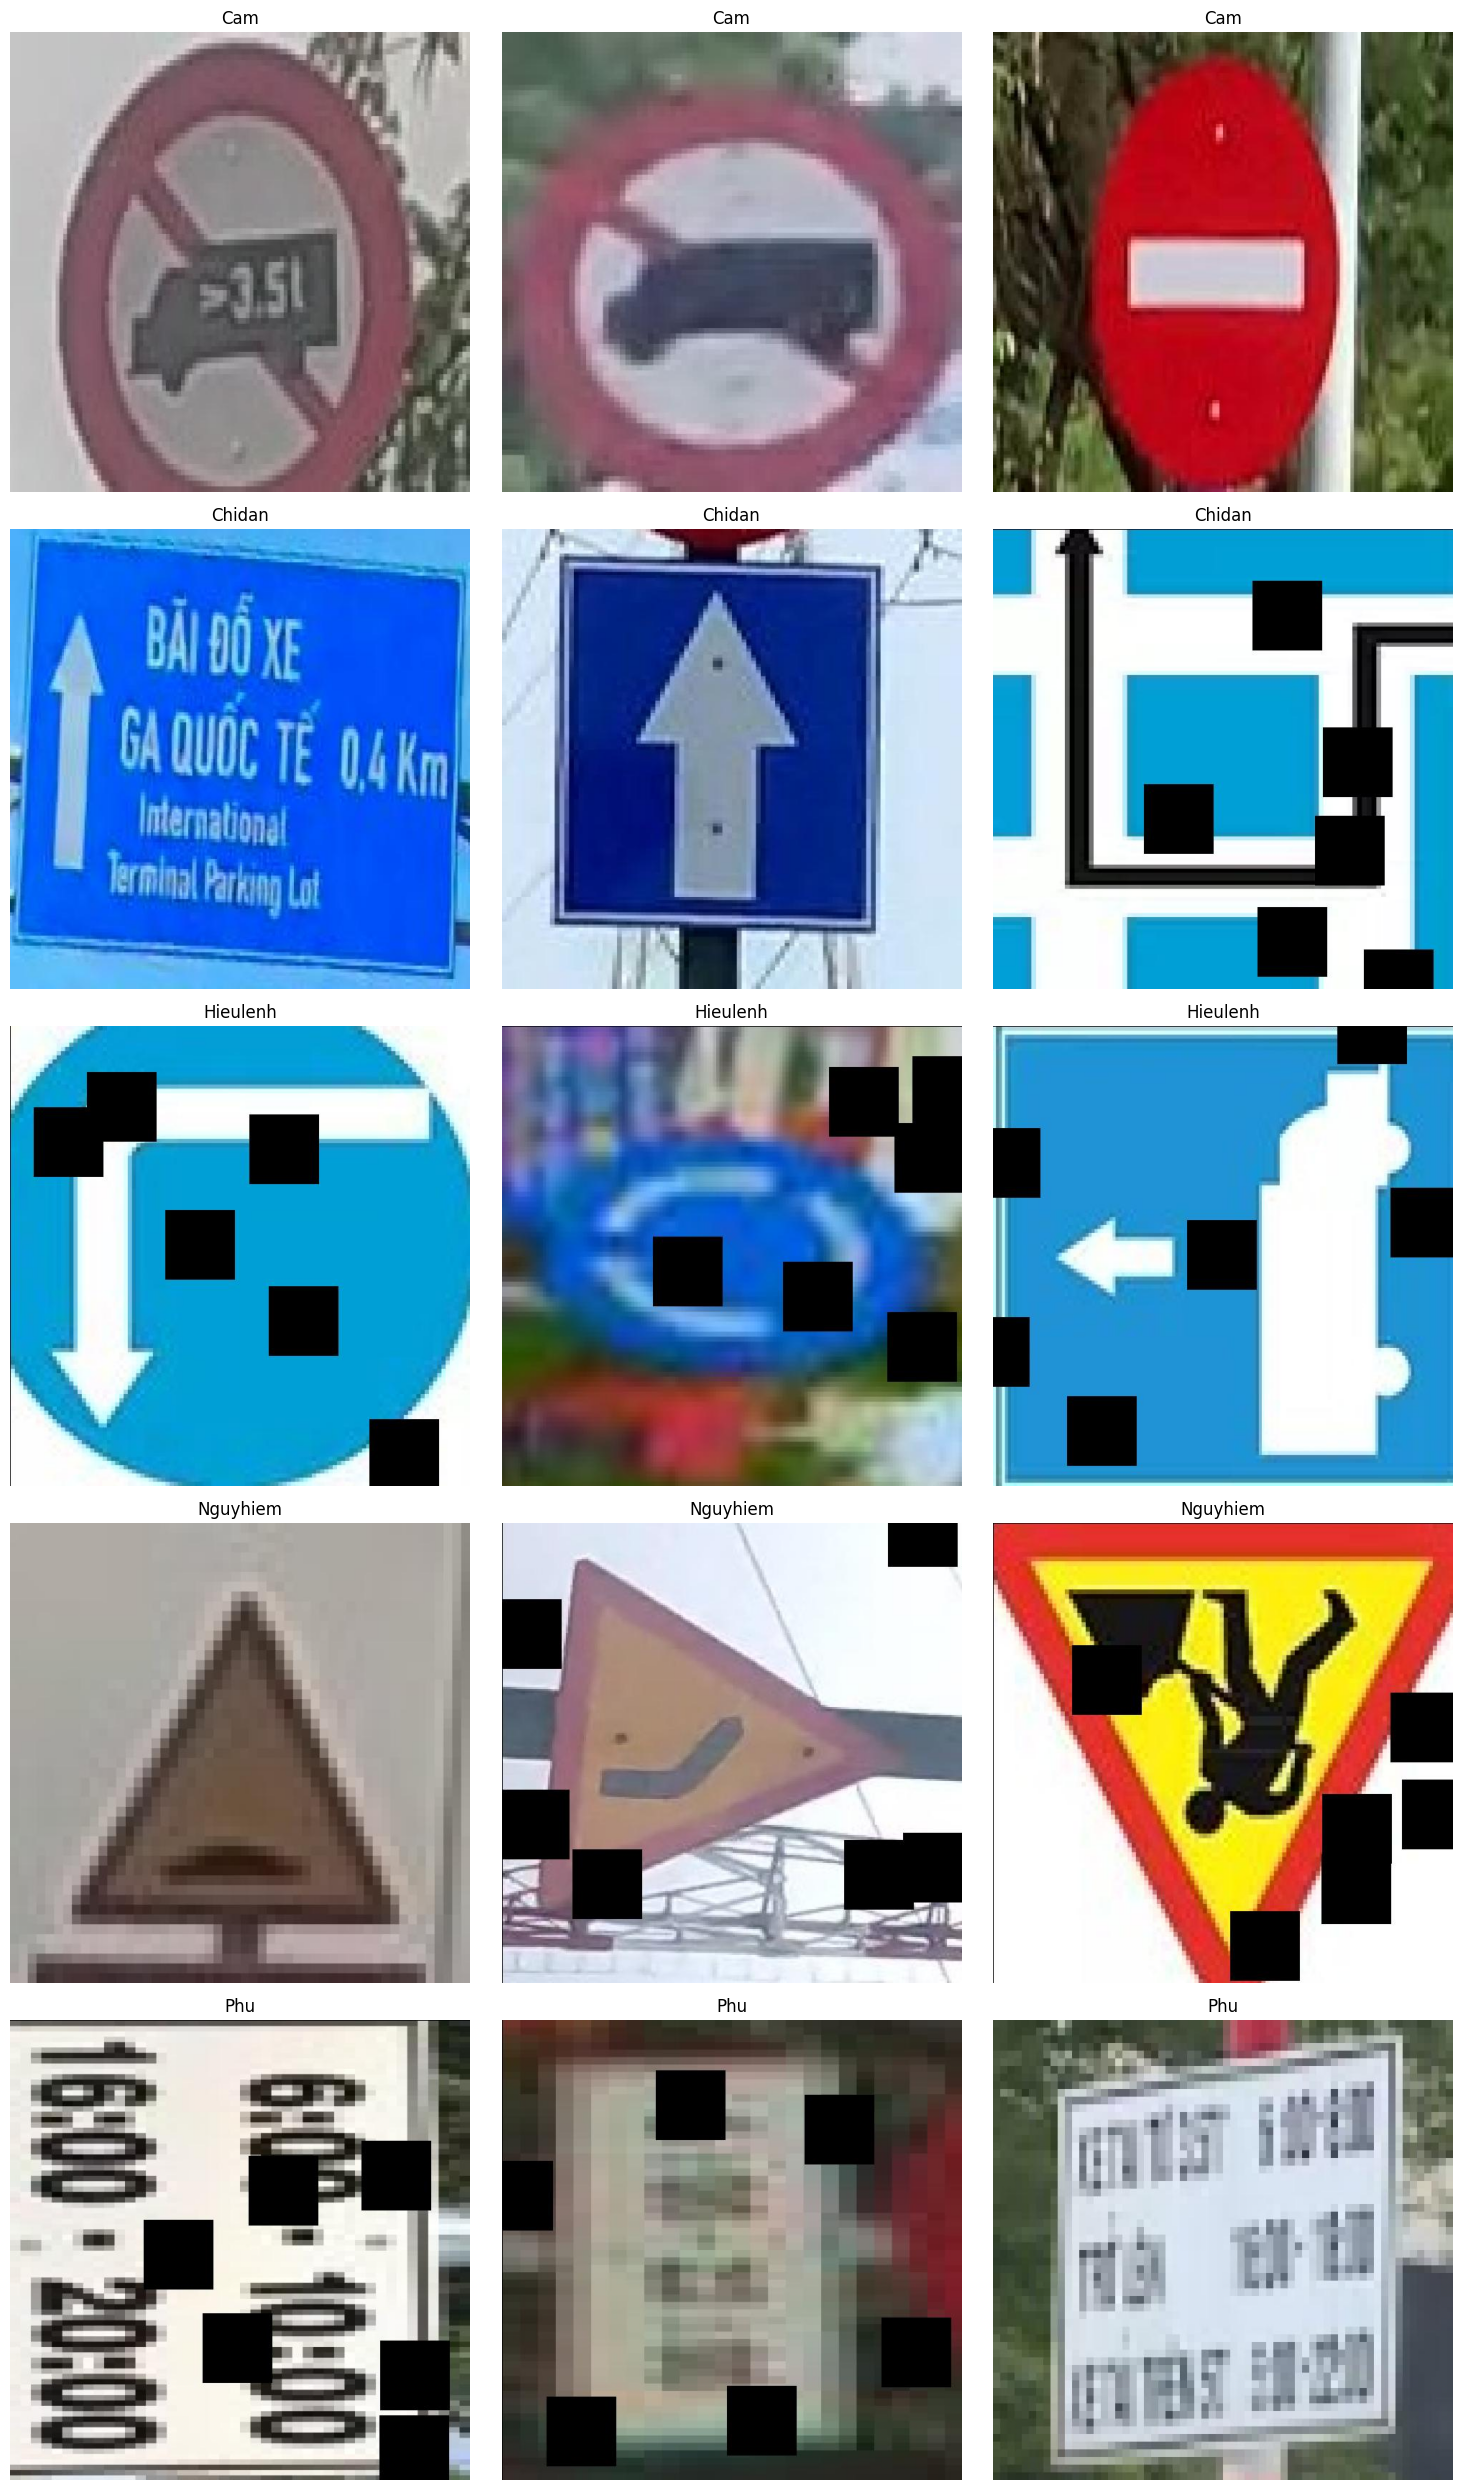

In [19]:
# Hàm để hiển thị ảnh từ mỗi label
def show_images_from_labels(label_dirs, num_samples=3):
    plt.figure(figsize=(15, len(label_dirs) * 5))  # Kích thước hình ảnh lớn
    for i, label_dir in enumerate(label_dirs):
        # Lấy danh sách các ảnh trong thư mục label
        img_files = os.listdir(label_dir)
        selected_images = np.random.choice(img_files, size=min(num_samples, len(img_files)), replace=False)

        for j, img_file in enumerate(selected_images):
            img_path = os.path.join(label_dir, img_file)
            img = Image.open(img_path).convert('RGB')  # Mở ảnh và chuyển sang RGB

            ax = plt.subplot(len(label_dirs), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(os.path.basename(label_dir))  # Tên label từ đường dẫn
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# Hiển thị ảnh từ các label
show_images_from_labels(label_dirs, num_samples=3)

In [20]:
# Tạo dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Load mô hình Swin Transformer cho phân loại ảnh, thêm ignore_mismatched_sizes=True
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

In [ ]:
# Khởi tạo TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
)

def custom_data_collator(features):
    images, labels = zip(*features)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": images, "labels": labels}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=custom_data_collator,
    compute_metrics=lambda p: {'accuracy': accuracy_score(np.argmax(p.predictions, axis=1), p.label_ids)}
)

In [ ]:
# Bắt đầu huấn luyện
trainer.train()

In [22]:
# Đánh giá mô hình trên tập valid
eval_results = trainer.evaluate(eval_dataset=valid_dataset)
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")

In [ ]:
# Đánh giá mô hình trên tập test
preds_output = trainer.predict(test_dataset)
test_preds = np.argmax(preds_output.predictions, axis=1)
test_labels = np.array(test_dataset.targets)

In [ ]:
# Tính độ chính xác
test_acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# Ma trận nhầm lẫn (confusion matrix)
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Lưu lại mô hình đã huấn luyện để deploy
model.save_pretrained("./swin_model")
feature_extractor.save_pretrained("./swin_model")